# Predict ETH price direction - Random Forest Classifier

In [41]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [42]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_6.csv', parse_dates=True)

In [43]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')

In [44]:
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [45]:
combined_df = combined_df.set_index('time')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
time,,,,,,,,,,,
2016-01-01 00:00:00+00:00,eth,2433,2.166056,7.010116e+07,0.483217,264.814266,0.920370,7.616628e+07,8233,264718.210777,1.362126
2016-01-02 00:00:00+00:00,eth,2486,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164,195513.065884,1.365054
2016-01-03 00:00:00+00:00,eth,2528,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258,311464.489292,1.369430
2016-01-04 00:00:00+00:00,eth,2623,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474,115686.914897,1.370961
2016-01-05 00:00:00+00:00,eth,2620,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430,645005.606026,1.384049


In [46]:
combined_df.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_metrics_combined.csv', header=False)

<AxesSubplot:title={'center':'EMA ETH'}, xlabel='time', ylabel='ETH Price ($)'>

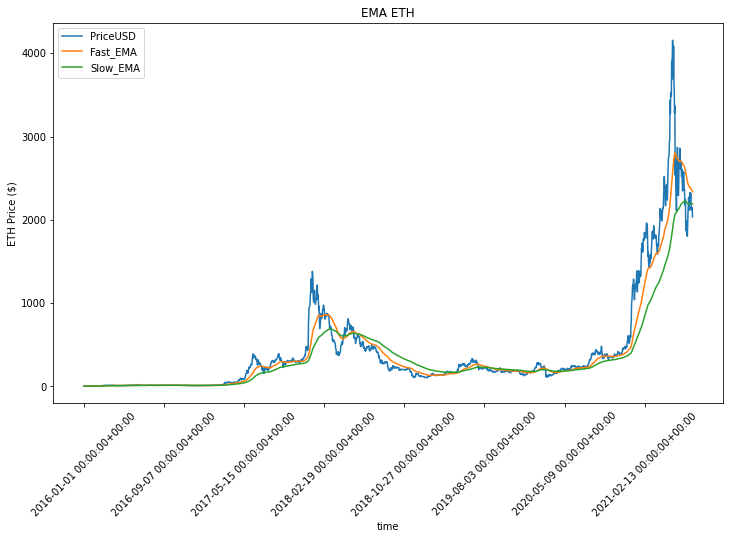

In [48]:
# Set short and long windows for EMA (Exponential Moving Average)
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
combined_df['Fast_EMA'] = combined_df['PriceUSD'].ewm(halflife=short_window).mean()
combined_df['Slow_EMA'] = combined_df['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
combined_df[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA ETH', ylabel='ETH Price ($)', rot=45) 

In [49]:
# Construct a crossover trading signal
combined_df['Crossover_Long'] = np.where(combined_df['Fast_EMA'] > combined_df['Slow_EMA'], 1.0, 0.0)
combined_df['Crossover_Short'] = np.where(combined_df['Fast_EMA'] < combined_df['Slow_EMA'],-1.0, 0.0)
combined_df['Crossover_Signal'] = combined_df['Crossover_Long'] + combined_df['Crossover_Short']

In [50]:
# Calculate daily return
combined_df['Daily_Return'] = combined_df['PriceUSD'].pct_change()

In [51]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
combined_df['Positive_Return'] = np.where(combined_df['Daily_Return'] > 0, 1.0, 0.0)

combined_df = combined_df.dropna()
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,
2021-07-08 00:00:00+00:00,eth,590368,1.508218,2.470993e+11,487.562763,26.174093,2118.924331,1.166154e+08,1262627,9.440605e+09,22.200455,2369.044064,2196.342353,1.0,0.0,1.0,-0.085519,0.0
2021-07-09 00:00:00+00:00,eth,595204,1.528143,2.511920e+11,485.362057,35.690899,2153.773738,1.166288e+08,1223691,7.037984e+09,22.216806,2361.711166,2195.756298,1.0,0.0,1.0,0.016447,1.0
2021-07-10 00:00:00+00:00,eth,546313,1.507265,2.469390e+11,503.737633,46.026242,2117.063967,1.166422e+08,1139265,5.365179e+09,22.223583,2353.377585,2194.672918,1.0,0.0,1.0,-0.017044,0.0
2021-07-11 00:00:00+00:00,eth,579907,1.520469,2.496654e+11,499.343026,93.072929,2140.192887,1.166556e+08,1101766,2.682471e+09,22.224362,2346.115731,2193.922875,1.0,0.0,1.0,0.010925,1.0
2021-07-12 00:00:00+00:00,eth,552707,1.469284,2.371913e+11,503.391952,34.003743,2033.031335,1.166688e+08,1191465,6.975448e+09,22.241962,2335.450927,2191.707834,1.0,0.0,1.0,-0.050071,0.0


In [52]:
# Select model features and timeframe for train data
X = combined_df[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal']]
X_train = X[:'2021']

In [53]:
# Select prediction variable and timeframe for train data
y = combined_df['Positive_Return']
y_train = y[:'2021']

In [54]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y["2021":]

In [55]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [56]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [57]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [58]:
# Create the decision tree classifier instance and calculate the optimal tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))


Best: 0.525146 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}


In [59]:
# Define the model using optimized settings
model = RandomForestClassifier(criterion='gini', max_depth=10,n_estimators=500, n_jobs=-1)

In [60]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [61]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [62]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [63]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,73,12
Actual 1,84,24


Accuracy Score : 0.5025906735751295
Classification Report
              precision    recall  f1-score   support

         0.0       0.46      0.86      0.60        85
         1.0       0.67      0.22      0.33       108

    accuracy                           0.50       193
   macro avg       0.57      0.54      0.47       193
weighted avg       0.58      0.50      0.45       193



In [64]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive_Return,Predicted Value
time,,
2021-01-01 00:00:00+00:00,1.0,1.0
2021-01-02 00:00:00+00:00,1.0,1.0
2021-01-03 00:00:00+00:00,1.0,0.0
2021-01-04 00:00:00+00:00,1.0,0.0
2021-01-05 00:00:00+00:00,1.0,0.0
...,...,...
2021-07-08 00:00:00+00:00,0.0,0.0
2021-07-09 00:00:00+00:00,1.0,0.0
2021-07-10 00:00:00+00:00,0.0,0.0


In [65]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)[:10]

[(0.1459757617438342, 'CapMVRVCur'),
 (0.13103117434285622, 'NVTAdj'),
 (0.12353057255217467, 'AdrActCnt'),
 (0.12152148887282392, 'CapMrktCurUSD'),
 (0.12020117482493604, 'TxCnt'),
 (0.11995141566146837, 'TxTfrValAdjUSD'),
 (0.11658949976876692, 'VelCur1yr'),
 (0.11417441151338581, 'HashRate'),
 (0.007024500719753906, 'Crossover_Signal')]

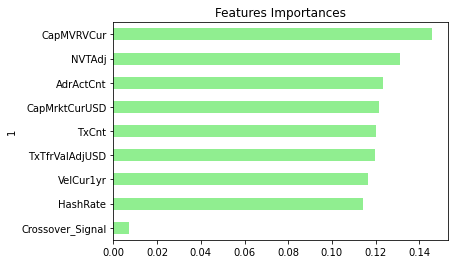

In [66]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))[:10]
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)